# HW2 - Algorithm Implementation and Basic Model Selection

## Imports & Style edit

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate #, GridSearchCV

# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier, plot_tree
# from matplotlib.pyplot import semilogx
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.svm import SVC

In [23]:
# Required test style for matplotlib.
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [24]:
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

## Preliminary: Data Loading

In [25]:
# !rm *.csv

# from google.colab import files
# print("Please load the modified Traing set csv data")
# uploadedData = files.upload()
# training_set_file = list(uploadedData)[0]

# print("Please load the modified Test set csv data")
# uploadedData = files.upload()
# test_set_file = list(uploadedData)[0]
training_set_file = "training_set.csv"
test_set_file = "test_set.csv"

In [26]:
training_set = pd.read_csv(training_set_file)
test_set = pd.read_csv(test_set_file)

## Part 1: Basic model selection with k-Nearest Neighbors

### Visualization and basic analysis

train 1.0


C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


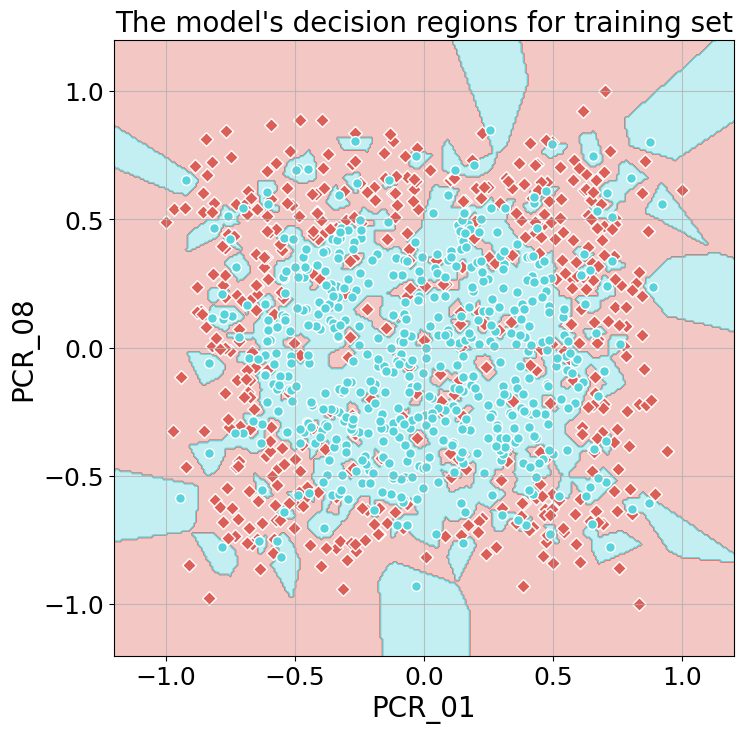

test 0.7


C:\Users\eyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


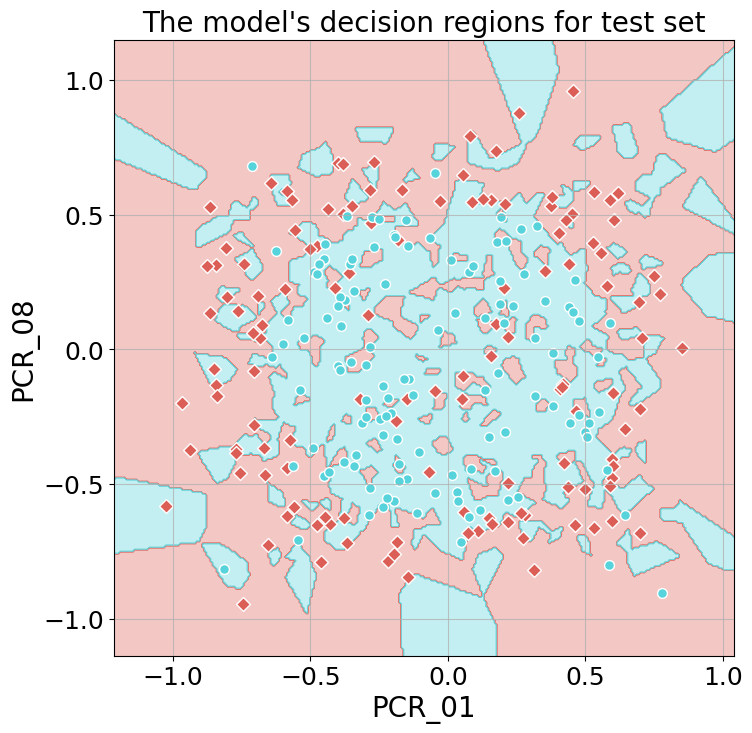

In [43]:
# Create dataframe containing only the PCR 01 & 08 values
training_set_01_08 = training_set[['PCR_01', 'PCR_08']]
test_set_01_08 = test_set[['PCR_01', 'PCR_08']]

# Create kNN classifier with k=1
kNNClassifier = KNeighborsClassifier(n_neighbors=1)
kNNClassifier.fit(training_set_01_08, training_set['spread'])

# Visualize the decision regions for training set
print("train", kNNClassifier.score(training_set_01_08, training_set["spread"]))
visualize_clf(kNNClassifier, training_set_01_08, training_set['spread'], "The model's decision regions for training set", 'PCR_01', 'PCR_08')

# Visualize the decision regions for test set
print("test", kNNClassifier.score(test_set_01_08, test_set["spread"]))
visualize_clf(kNNClassifier, test_set_01_08, test_set['spread'], "The model's decision regions for test set", 'PCR_01', 'PCR_08')

### Model selection

In [45]:
# create list of options for the k value
kOptions = list(range(1, 20, 2)) + list(range(20, 695, 65))

dictKVal = []
dictKTrain = []
for k in kOptions:
  kNNClassifier = KNeighborsClassifier(n_neighbors=k)
  dictKVal.append(np.mean(cross_validate(kNNClassifier, test_set_01_08, test_set['spread'], cv=8, return_train_score=True)['test_score']))
  dictKTrain.append(np.mean(cross_validate(kNNClassifier, training_set_01_08, training_set['spread'], cv=8, return_train_score=True)['train_score']))